# Grassmann Manifold

Author: Ketson R. M. dos Santos,  
Date: June 3rd, 2020   

This example shows how to use the UQpy Grassmann class to
* perform interpolation on the Grassmann manifold;

Import the necessary libraries. Here we import standard libraries such as numpy and matplotlib, but also need to import the Grassmann class from UQpy implemented in the DimensionReduction module.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from UQpy.DimensionReduction import Grassmann

Generate the initial samples located at the vertices of a triangle. The coordinates of each vertix are stored in `nodes` and `point` contain the point to be interpolated on the tangent space.

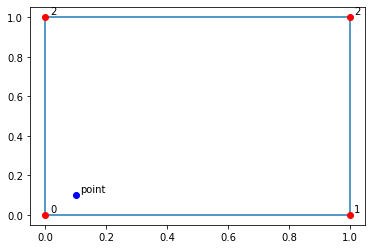

In [2]:
nodes = np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) # node_0, node_1, node_2.
point = np.array([0.1, 0.1]) # Point to interpolate.

plot_ = nodes[0:]
Xplot = plot_.T[0].tolist()
Xplot.append(plot_[0][0])
Yplot = plot_.T[1].tolist()
Yplot.append(plot_[0][1])
plt.plot(Xplot,Yplot)
plt.plot(nodes[0][0],nodes[0][1],'ro')
plt.plot(nodes[1][0],nodes[1][1],'ro')
plt.plot(nodes[2][0],nodes[2][1],'ro')
plt.plot(nodes[3][0],nodes[3][1],'ro')
plt.plot(point[0],point[1],'bo')

dt = 0.015
plt.text(nodes[0][0]+dt,nodes[0][1]+dt,'0')
plt.text(nodes[1][0]+dt,nodes[1][1]+dt,'1')
plt.text(nodes[2][0]+dt,nodes[2][1]+dt,'2')
plt.text(nodes[3][0]+dt,nodes[3][1]+dt,'2')
plt.text(point[0]+dt,point[1]+dt,'point')
plt.show()
plt.close()


Generate three random matrices with reduced rank corresponding to the different samples. The samples are stored in `Solutions`.

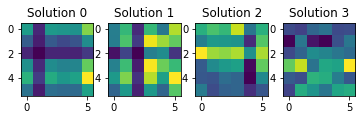

In [3]:
D1 = 6 
r0 = 2  # rank sample 0
r1 = 3  # rank sample 1
r2 = 4  # rank sample 2
r3 = 3  # rank sample 2

np.random.seed(1111) # For reproducibility.
# Solutions: original space.
Sol0 = np.dot(np.random.rand(D1, r0),np.random.rand(r0, D1))
Sol1 = np.dot(np.random.rand(D1, r1),np.random.rand(r1, D1))
Sol2 = np.dot(np.random.rand(D1, r2),np.random.rand(r2, D1))
Sol3 = np.dot(np.random.rand(D1, r3),np.random.rand(r3, D1))

# Creating a list of solutions.
Solutions = [Sol0, Sol1, Sol2, Sol3]

# Plot the solutions
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.title.set_text('Solution 0')
ax1.imshow(Sol0)
ax2.title.set_text('Solution 1')
ax2.imshow(Sol1)
ax3.title.set_text('Solution 2')
ax3.imshow(Sol2)
ax4.title.set_text('Solution 3')
ax4.imshow(Sol3)
plt.show()

Firs, let's perform the interpolation step-by-step using an object of the ``UQpy.Kriging`` class to interpolate. Further, instatiate the ``UQpy`` class ``Grassmann`` considering the `grassmann_distance` for the distance, `gradient_descent` to estimate the Karcher mean.

In [4]:
from UQpy.Surrogates import Kriging

Krig = Kriging(reg_model='Linear', corr_model='Exponential', corr_model_params=[1.0,1.0], n_opt=1)

Gr = Grassmann(distance_method=Grassmann.grassmann_distance, interp_object=Krig, 
               karcher_method=Grassmann.gradient_descent)

Gr.manifold(p="max", samples=Solutions)

Compute the Karcher mean for $\Psi$ and $\Phi$, the left and right -singular eigenvectors, respectively, of singular value decomposition of each solution.

In [5]:
karcher_psi, karcher_phi = Gr.karcher_mean()

Rearrange the singular values $\Sigma$ of each solution as a diagonal matrix.

In [6]:
sigma_m = []
for i in range(len(Gr.sigma)):
    sigma_m.append(np.diag(Gr.sigma[i]))

Select the Karcher mean as a reference point for $\Psi$ and $\Phi$ and map those points on the manifold to the tangent space generated at the reference point.

In [7]:
gammaPsi = Gr.log_map(Gr.psi, ref=karcher_psi)
gammaPhi = Gr.log_map(Gr.phi, ref=karcher_phi)

Perform the standard linear interpolation of `point` on the tangent space for $\Psi$, $\Phi$, and $\Sigma$. The interpolated points are given by $\tilde{\Psi}$, $\tilde{\Phi}$, and $\tilde{\Sigma}$. Thus, the interpolated solution is given by $\tilde{\mathrm{X}}=\tilde{\Psi}\tilde{\Phi}\tilde{\Sigma}$.

In [8]:
interpPsi = Gr.interpolate_sample(coordinates=nodes, samples=gammaPsi, point=point)
interpPhi = Gr.interpolate_sample(coordinates=nodes, samples=gammaPhi, point=point)
interpS = Gr.interpolate_sample(coordinates=nodes, samples=sigma_m, point=point)


In [9]:
#PsiTilde = Gr.exp_mapping(interpPsi, ref=ref_psi,rank_ref=max_rank)
#PhiTilde = Gr.exp_mapping(interpPhi, ref=ref_phi,rank_ref=max_rank)

PsiTilde = Gr.exp_map([interpPsi], ref=karcher_psi)
PhiTilde = Gr.exp_map([interpPhi], ref=karcher_phi)

PsiTilde = np.array(PsiTilde[0])
PhiTilde = np.array(PhiTilde[0])
SolTilde = np.dot(np.dot(PsiTilde, interpS),PhiTilde.T)

Print the interpolated solution and compare to the given solutions associated to the different vertices of the triangle.

[[0.65058578 0.15997151 0.63279076 0.61285645 0.60173658 0.94037845]
 [0.36356653 0.12756156 0.34794897 0.28160916 0.32153957 0.57679911]
 [0.15529489 0.03544985 0.15145383 0.15065183 0.14469022 0.2207925 ]
 [0.59300055 0.16563232 0.57383432 0.52699713 0.54082604 0.88377849]
 [0.74489157 0.23393673 0.71696915 0.62070422 0.6693657  1.14492744]
 [0.45643461 0.12005378 0.44278736 0.41748883 0.41914465 0.67025722]]
 
[[0.60966666 0.83740533 0.31712613 0.84306651 0.58301809 1.04881107]
 [0.60785235 0.88596601 0.36718095 1.13323508 1.01713178 0.92996841]
 [0.2464859  0.39818036 0.20049917 0.61497793 0.66483533 0.34348345]
 [0.62238022 0.85848369 0.2767713  1.15025462 0.94342018 0.84554589]
 [0.71519376 0.97392451 0.34238686 1.05344459 0.7450903  1.15847017]
 [0.51218462 0.71530438 0.29063148 0.70981172 0.51250408 0.90768646]]
 
[[1.19651614 1.32294781 1.25181197 1.62903871 0.83929742 1.20041643]
 [0.89296687 1.0550084  1.04233584 1.02247984 0.43543934 1.35114872]
 [1.75345633 1.53238807 1.49

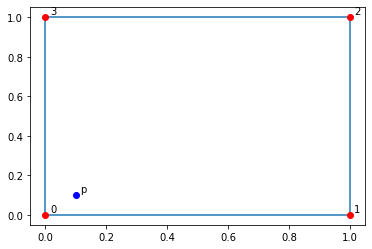

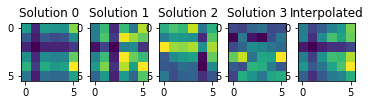

In [10]:
print(Sol0)
print(" ")
print(Sol1)
print(" ")
print(Sol2)
print("-------------------------")
print(SolTilde)

plot_ = nodes[0:]
Xplot = plot_.T[0].tolist()
Xplot.append(plot_[0][0])
Yplot = plot_.T[1].tolist()
Yplot.append(plot_[0][1])
plt.plot(Xplot,Yplot)
plt.plot(nodes[0][0],nodes[0][1],'ro')
plt.plot(nodes[1][0],nodes[1][1],'ro')
plt.plot(nodes[2][0],nodes[2][1],'ro')
plt.plot(nodes[3][0],nodes[3][1],'ro')
plt.plot(point[0],point[1],'bo')

dt = 0.015
plt.text(nodes[0][0]+dt,nodes[0][1]+dt,'0')
plt.text(nodes[1][0]+dt,nodes[1][1]+dt,'1')
plt.text(nodes[2][0]+dt,nodes[2][1]+dt,'2')
plt.text(nodes[3][0]+dt,nodes[3][1]+dt,'3')
plt.text(point[0]+dt,point[1]+dt,'p')
plt.show()
plt.close()


# Plot the solutions
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.title.set_text('Solution 0')
ax1.imshow(Sol0)
ax2.title.set_text('Solution 1')
ax2.imshow(Sol1)
ax3.title.set_text('Solution 2')
ax3.imshow(Sol2)
ax4.title.set_text('Solution 3')
ax4.imshow(Sol3)
ax5.title.set_text('Interpolated')
ax5.imshow(SolTilde)
plt.show()

All the operations above are implemented in the method `interpolate`, which is used below. in this case, the interpolation is performed on the entries of the input matrices.

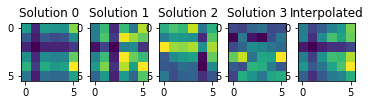

In [11]:

X = Gr.interpolate(coordinates=nodes, point=point, element_wise=True)

# Plot the solutions
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.title.set_text('Solution 0')
ax1.imshow(Sol0)
ax2.title.set_text('Solution 1')
ax2.imshow(Sol1)
ax3.title.set_text('Solution 2')
ax3.imshow(Sol2)
ax4.title.set_text('Solution 3')
ax4.imshow(Sol3)
ax5.title.set_text('Interpolated')
ax5.imshow(X)
plt.show()

Now, let's use an object of sklearn.gaussiann_process. (To run this example, you have to install the scikit learn toolbox in advance.)

In [12]:
from sklearn.gaussian_process import GaussianProcessRegressor
gp = GaussianProcessRegressor()

# Instantiate the method again with: interp_object=gp.
Gr = Grassmann(distance_method=Grassmann.grassmann_distance, interp_object=gp, karcher_method=Grassmann.gradient_descent)

Gr.manifold(p='max', samples=Solutions)
X = Gr.interpolate(coordinates=nodes, point=[point], element_wise=True)

Plot the solution.

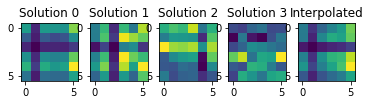

In [13]:

# Plot the solutions
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.title.set_text('Solution 0')
ax1.imshow(Sol0)
ax2.title.set_text('Solution 1')
ax2.imshow(Sol1)
ax3.title.set_text('Solution 2')
ax3.imshow(Sol2)
ax4.title.set_text('Solution 3')
ax4.imshow(Sol3)
ax5.title.set_text('Interpolated')
ax5.imshow(X)
plt.show()